## Imports

In [27]:
import numpy as np  
import matplotlib.pyplot as plt 
import os                  
from PIL import Image
import tensorflow as tf
import pandas as pd 
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D,MaxPooling2D,Dense,Flatten,Dropout  
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2
from tensorflow.keras.optimizers import Adam 
from tensorflow.keras import Model, layers
from tensorflow.keras.models import load_model
import keras 
from aipilot.tf.cv import DataPrep , GradCam
from aipilot.tf import Devices, callbacks, Evaluator

In [28]:
devices = Devices()

In [29]:
devices.gpu_device

[INFO] Tensorflow is built with cuda support ✅
[INFO] [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
[INFO] {'device_name': 'NVIDIA GeForce RTX 3050 Ti Laptop GPU', 'compute_capability': (8, 6)}


## Project Directories

In [80]:
BASE_DIR = os.path.relpath(os.getcwd())
DATA_DIR = os.path.join(BASE_DIR, "dataset") 

TRAIN_DIR = os.path.join(DATA_DIR, "train")
TEST_DIR = os.path.join(DATA_DIR, "test")

ARTIFACTS_DIR = os.path.join(BASE_DIR, 'artifacts')
os.makedirs(ARTIFACTS_DIR, exist_ok=True)

CKPT_DIR = os.path.join(ARTIFACTS_DIR, "ckpt")
os.makedirs(CKPT_DIR, exist_ok=True)

MODELS_DIR = os.path.join(ARTIFACTS_DIR, "models")
os.makedirs(MODELS_DIR, exist_ok=True)

LOGS_DIR = os.path.join(BASE_DIR, "logs")
os.makedirs(LOGS_DIR, exist_ok=True)

CKPT_FILE_NAME = os.path.join(CKPT_DIR, ".mdl_wts_mobilenetv2.hdf5")
MODEL_NAME = os.path.join(MODELS_DIR, "model.h5")

## Data Preprocessing

In [32]:
data_ops = DataPrep(TRAIN_DIR)

In [33]:
train_generator, valid_generator = data_ops.data_generators(train_dir=TRAIN_DIR, val_dir=TEST_DIR, batch_size=16,
                                                            data_augmentation= True)

Found 2637 images belonging to 2 classes.
Found 660 images belonging to 2 classes.


In [34]:
data_ops.classwise_img_count(train_generator)

{'benign': 1440, 'malignant': 1197}

In [35]:
data_ops.classwise_img_count(valid_generator)

{'benign': 360, 'malignant': 300}

In [36]:
steps_per_epoch = train_generator.samples // train_generator.batch_size
validation_steps = valid_generator.samples // valid_generator.batch_size

## Checking Sample Images

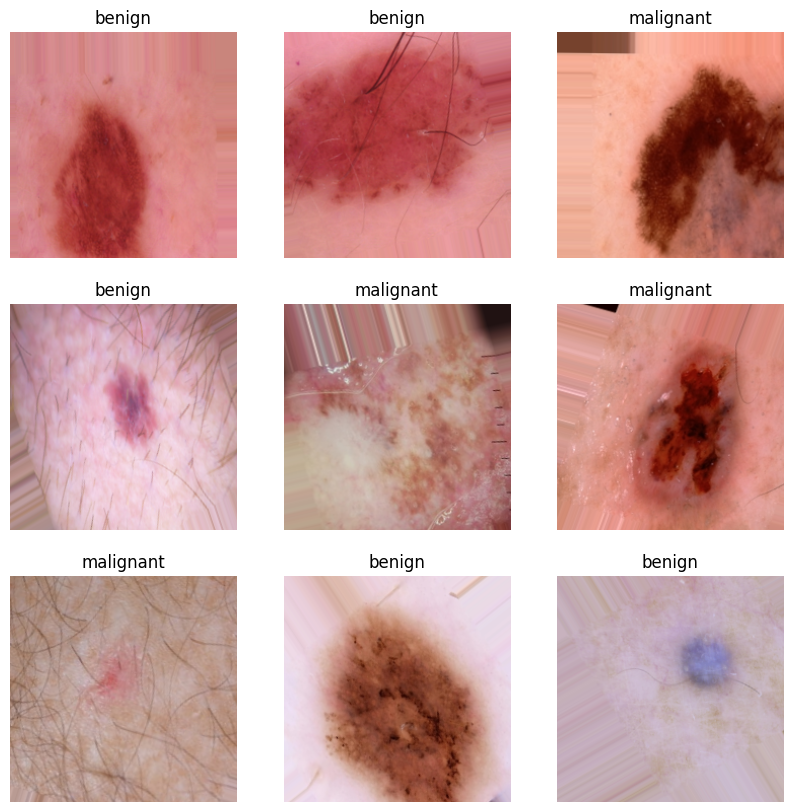

In [37]:
data_ops.sample_images(train_generator)

## Model Training

In [38]:
(early_stopping_cb, checkpointing_cb,
 tensorboard_cb, reduce_on_plateau_cb) = callbacks(
                                                   CKPT_FILE_NAME, CKPT_DIR, LOGS_DIR, es_patience=7, lr_patience=3
                                                    )

In [106]:
conv_base = tf.keras.applications.densenet.DenseNet201(
        include_top=False,
        weights='imagenet'
)

for layer in conv_base.layers[:-20]:
    layer.trainable = False

In [107]:
conv_base.summary()

Model: "densenet201"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 zero_padding2d (ZeroPadding2D)  (None, None, None,   0          ['input_4[0][0]']                
                                3)                                                                
                                                                                                  
 conv1/conv (Conv2D)            (None, None, None,   9408        ['zero_padding2d[0][0]']         
                                64)                                                     

                                                                                                  
 conv2_block3_concat (Concatena  (None, None, None,   0          ['conv2_block2_concat[0][0]',    
 te)                            160)                              'conv2_block3_2_conv[0][0]']    
                                                                                                  
 conv2_block4_0_bn (BatchNormal  (None, None, None,   640        ['conv2_block3_concat[0][0]']    
 ization)                       160)                                                              
                                                                                                  
 conv2_block4_0_relu (Activatio  (None, None, None,   0          ['conv2_block4_0_bn[0][0]']      
 n)                             160)                                                              
                                                                                                  
 conv2_blo

 n)                             128)                                                              
                                                                                                  
 conv3_block1_1_conv (Conv2D)   (None, None, None,   16384       ['conv3_block1_0_relu[0][0]']    
                                128)                                                              
                                                                                                  
 conv3_block1_1_bn (BatchNormal  (None, None, None,   512        ['conv3_block1_1_conv[0][0]']    
 ization)                       128)                                                              
                                                                                                  
 conv3_block1_1_relu (Activatio  (None, None, None,   0          ['conv3_block1_1_bn[0][0]']      
 n)                             128)                                                              
          

 conv3_block5_0_relu (Activatio  (None, None, None,   0          ['conv3_block5_0_bn[0][0]']      
 n)                             256)                                                              
                                                                                                  
 conv3_block5_1_conv (Conv2D)   (None, None, None,   32768       ['conv3_block5_0_relu[0][0]']    
                                128)                                                              
                                                                                                  
 conv3_block5_1_bn (BatchNormal  (None, None, None,   512        ['conv3_block5_1_conv[0][0]']    
 ization)                       128)                                                              
                                                                                                  
 conv3_block5_1_relu (Activatio  (None, None, None,   0          ['conv3_block5_1_bn[0][0]']      
 n)       

                                                                                                  
 conv3_block9_0_relu (Activatio  (None, None, None,   0          ['conv3_block9_0_bn[0][0]']      
 n)                             384)                                                              
                                                                                                  
 conv3_block9_1_conv (Conv2D)   (None, None, None,   49152       ['conv3_block9_0_relu[0][0]']    
                                128)                                                              
                                                                                                  
 conv3_block9_1_bn (BatchNormal  (None, None, None,   512        ['conv3_block9_1_conv[0][0]']    
 ization)                       128)                                                              
                                                                                                  
 conv3_blo

                                512)                                                              
                                                                                                  
 pool3_relu (Activation)        (None, None, None,   0           ['pool3_bn[0][0]']               
                                512)                                                              
                                                                                                  
 pool3_conv (Conv2D)            (None, None, None,   131072      ['pool3_relu[0][0]']             
                                256)                                                              
                                                                                                  
 pool3_pool (AveragePooling2D)  (None, None, None,   0           ['pool3_conv[0][0]']             
                                256)                                                              
          

 conv4_block4_1_bn (BatchNormal  (None, None, None,   512        ['conv4_block4_1_conv[0][0]']    
 ization)                       128)                                                              
                                                                                                  
 conv4_block4_1_relu (Activatio  (None, None, None,   0          ['conv4_block4_1_bn[0][0]']      
 n)                             128)                                                              
                                                                                                  
 conv4_block4_2_conv (Conv2D)   (None, None, None,   36864       ['conv4_block4_1_relu[0][0]']    
                                32)                                                               
                                                                                                  
 conv4_block4_concat (Concatena  (None, None, None,   0          ['conv4_block3_concat[0][0]',    
 te)      

                                                                                                  
 conv4_block8_1_bn (BatchNormal  (None, None, None,   512        ['conv4_block8_1_conv[0][0]']    
 ization)                       128)                                                              
                                                                                                  
 conv4_block8_1_relu (Activatio  (None, None, None,   0          ['conv4_block8_1_bn[0][0]']      
 n)                             128)                                                              
                                                                                                  
 conv4_block8_2_conv (Conv2D)   (None, None, None,   36864       ['conv4_block8_1_relu[0][0]']    
                                32)                                                               
                                                                                                  
 conv4_blo

                                128)                                                              
                                                                                                  
 conv4_block12_1_bn (BatchNorma  (None, None, None,   512        ['conv4_block12_1_conv[0][0]']   
 lization)                      128)                                                              
                                                                                                  
 conv4_block12_1_relu (Activati  (None, None, None,   0          ['conv4_block12_1_bn[0][0]']     
 on)                            128)                                                              
                                                                                                  
 conv4_block12_2_conv (Conv2D)  (None, None, None,   36864       ['conv4_block12_1_relu[0][0]']   
                                32)                                                               
          

 conv4_block16_1_conv (Conv2D)  (None, None, None,   94208       ['conv4_block16_0_relu[0][0]']   
                                128)                                                              
                                                                                                  
 conv4_block16_1_bn (BatchNorma  (None, None, None,   512        ['conv4_block16_1_conv[0][0]']   
 lization)                      128)                                                              
                                                                                                  
 conv4_block16_1_relu (Activati  (None, None, None,   0          ['conv4_block16_1_bn[0][0]']     
 on)                            128)                                                              
                                                                                                  
 conv4_block16_2_conv (Conv2D)  (None, None, None,   36864       ['conv4_block16_1_relu[0][0]']   
          

                                                                                                  
 conv4_block20_1_conv (Conv2D)  (None, None, None,   110592      ['conv4_block20_0_relu[0][0]']   
                                128)                                                              
                                                                                                  
 conv4_block20_1_bn (BatchNorma  (None, None, None,   512        ['conv4_block20_1_conv[0][0]']   
 lization)                      128)                                                              
                                                                                                  
 conv4_block20_1_relu (Activati  (None, None, None,   0          ['conv4_block20_1_bn[0][0]']     
 on)                            128)                                                              
                                                                                                  
 conv4_blo

 on)                            992)                                                              
                                                                                                  
 conv4_block24_1_conv (Conv2D)  (None, None, None,   126976      ['conv4_block24_0_relu[0][0]']   
                                128)                                                              
                                                                                                  
 conv4_block24_1_bn (BatchNorma  (None, None, None,   512        ['conv4_block24_1_conv[0][0]']   
 lization)                      128)                                                              
                                                                                                  
 conv4_block24_1_relu (Activati  (None, None, None,   0          ['conv4_block24_1_bn[0][0]']     
 on)                            128)                                                              
          

 conv4_block28_0_relu (Activati  (None, None, None,   0          ['conv4_block28_0_bn[0][0]']     
 on)                            1120)                                                             
                                                                                                  
 conv4_block28_1_conv (Conv2D)  (None, None, None,   143360      ['conv4_block28_0_relu[0][0]']   
                                128)                                                              
                                                                                                  
 conv4_block28_1_bn (BatchNorma  (None, None, None,   512        ['conv4_block28_1_conv[0][0]']   
 lization)                      128)                                                              
                                                                                                  
 conv4_block28_1_relu (Activati  (None, None, None,   0          ['conv4_block28_1_bn[0][0]']     
 on)      

                                                                                                  
 conv4_block32_0_relu (Activati  (None, None, None,   0          ['conv4_block32_0_bn[0][0]']     
 on)                            1248)                                                             
                                                                                                  
 conv4_block32_1_conv (Conv2D)  (None, None, None,   159744      ['conv4_block32_0_relu[0][0]']   
                                128)                                                              
                                                                                                  
 conv4_block32_1_bn (BatchNorma  (None, None, None,   512        ['conv4_block32_1_conv[0][0]']   
 lization)                      128)                                                              
                                                                                                  
 conv4_blo

 lization)                      1376)                                                             
                                                                                                  
 conv4_block36_0_relu (Activati  (None, None, None,   0          ['conv4_block36_0_bn[0][0]']     
 on)                            1376)                                                             
                                                                                                  
 conv4_block36_1_conv (Conv2D)  (None, None, None,   176128      ['conv4_block36_0_relu[0][0]']   
                                128)                                                              
                                                                                                  
 conv4_block36_1_bn (BatchNorma  (None, None, None,   512        ['conv4_block36_1_conv[0][0]']   
 lization)                      128)                                                              
          

 conv4_block40_0_bn (BatchNorma  (None, None, None,   6016       ['conv4_block39_concat[0][0]']   
 lization)                      1504)                                                             
                                                                                                  
 conv4_block40_0_relu (Activati  (None, None, None,   0          ['conv4_block40_0_bn[0][0]']     
 on)                            1504)                                                             
                                                                                                  
 conv4_block40_1_conv (Conv2D)  (None, None, None,   192512      ['conv4_block40_0_relu[0][0]']   
                                128)                                                              
                                                                                                  
 conv4_block40_1_bn (BatchNorma  (None, None, None,   512        ['conv4_block40_1_conv[0][0]']   
 lization)

                                                                                                  
 conv4_block44_0_bn (BatchNorma  (None, None, None,   6528       ['conv4_block43_concat[0][0]']   
 lization)                      1632)                                                             
                                                                                                  
 conv4_block44_0_relu (Activati  (None, None, None,   0          ['conv4_block44_0_bn[0][0]']     
 on)                            1632)                                                             
                                                                                                  
 conv4_block44_1_conv (Conv2D)  (None, None, None,   208896      ['conv4_block44_0_relu[0][0]']   
                                128)                                                              
                                                                                                  
 conv4_blo

 ate)                           1760)                             'conv4_block47_2_conv[0][0]']   
                                                                                                  
 conv4_block48_0_bn (BatchNorma  (None, None, None,   7040       ['conv4_block47_concat[0][0]']   
 lization)                      1760)                                                             
                                                                                                  
 conv4_block48_0_relu (Activati  (None, None, None,   0          ['conv4_block48_0_bn[0][0]']     
 on)                            1760)                                                             
                                                                                                  
 conv4_block48_1_conv (Conv2D)  (None, None, None,   225280      ['conv4_block48_0_relu[0][0]']   
                                128)                                                              
          

 conv5_block3_1_conv (Conv2D)   (None, None, None,   122880      ['conv5_block3_0_relu[0][0]']    
                                128)                                                              
                                                                                                  
 conv5_block3_1_bn (BatchNormal  (None, None, None,   512        ['conv5_block3_1_conv[0][0]']    
 ization)                       128)                                                              
                                                                                                  
 conv5_block3_1_relu (Activatio  (None, None, None,   0          ['conv5_block3_1_bn[0][0]']      
 n)                             128)                                                              
                                                                                                  
 conv5_block3_2_conv (Conv2D)   (None, None, None,   36864       ['conv5_block3_1_relu[0][0]']    
          

                                                                                                  
 conv5_block7_1_conv (Conv2D)   (None, None, None,   139264      ['conv5_block7_0_relu[0][0]']    
                                128)                                                              
                                                                                                  
 conv5_block7_1_bn (BatchNormal  (None, None, None,   512        ['conv5_block7_1_conv[0][0]']    
 ization)                       128)                                                              
                                                                                                  
 conv5_block7_1_relu (Activatio  (None, None, None,   0          ['conv5_block7_1_bn[0][0]']      
 n)                             128)                                                              
                                                                                                  
 conv5_blo

 on)                            1216)                                                             
                                                                                                  
 conv5_block11_1_conv (Conv2D)  (None, None, None,   155648      ['conv5_block11_0_relu[0][0]']   
                                128)                                                              
                                                                                                  
 conv5_block11_1_bn (BatchNorma  (None, None, None,   512        ['conv5_block11_1_conv[0][0]']   
 lization)                      128)                                                              
                                                                                                  
 conv5_block11_1_relu (Activati  (None, None, None,   0          ['conv5_block11_1_bn[0][0]']     
 on)                            128)                                                              
          

 conv5_block15_0_relu (Activati  (None, None, None,   0          ['conv5_block15_0_bn[0][0]']     
 on)                            1344)                                                             
                                                                                                  
 conv5_block15_1_conv (Conv2D)  (None, None, None,   172032      ['conv5_block15_0_relu[0][0]']   
                                128)                                                              
                                                                                                  
 conv5_block15_1_bn (BatchNorma  (None, None, None,   512        ['conv5_block15_1_conv[0][0]']   
 lization)                      128)                                                              
                                                                                                  
 conv5_block15_1_relu (Activati  (None, None, None,   0          ['conv5_block15_1_bn[0][0]']     
 on)      

                                                                                                  
 conv5_block19_0_relu (Activati  (None, None, None,   0          ['conv5_block19_0_bn[0][0]']     
 on)                            1472)                                                             
                                                                                                  
 conv5_block19_1_conv (Conv2D)  (None, None, None,   188416      ['conv5_block19_0_relu[0][0]']   
                                128)                                                              
                                                                                                  
 conv5_block19_1_bn (BatchNorma  (None, None, None,   512        ['conv5_block19_1_conv[0][0]']   
 lization)                      128)                                                              
                                                                                                  
 conv5_blo

 lization)                      1600)                                                             
                                                                                                  
 conv5_block23_0_relu (Activati  (None, None, None,   0          ['conv5_block23_0_bn[0][0]']     
 on)                            1600)                                                             
                                                                                                  
 conv5_block23_1_conv (Conv2D)  (None, None, None,   204800      ['conv5_block23_0_relu[0][0]']   
                                128)                                                              
                                                                                                  
 conv5_block23_1_bn (BatchNorma  (None, None, None,   512        ['conv5_block23_1_conv[0][0]']   
 lization)                      128)                                                              
          

 conv5_block27_0_bn (BatchNorma  (None, None, None,   6912       ['conv5_block26_concat[0][0]']   
 lization)                      1728)                                                             
                                                                                                  
 conv5_block27_0_relu (Activati  (None, None, None,   0          ['conv5_block27_0_bn[0][0]']     
 on)                            1728)                                                             
                                                                                                  
 conv5_block27_1_conv (Conv2D)  (None, None, None,   221184      ['conv5_block27_0_relu[0][0]']   
                                128)                                                              
                                                                                                  
 conv5_block27_1_bn (BatchNorma  (None, None, None,   512        ['conv5_block27_1_conv[0][0]']   
 lization)

                                                                                                  
 conv5_block31_0_bn (BatchNorma  (None, None, None,   7424       ['conv5_block30_concat[0][0]']   
 lization)                      1856)                                                             
                                                                                                  
 conv5_block31_0_relu (Activati  (None, None, None,   0          ['conv5_block31_0_bn[0][0]']     
 on)                            1856)                                                             
                                                                                                  
 conv5_block31_1_conv (Conv2D)  (None, None, None,   237568      ['conv5_block31_0_relu[0][0]']   
                                128)                                                              
                                                                                                  
 conv5_blo

In [108]:
x = conv_base.output
x = layers.Conv2D(filters = 32, kernel_size =  (3,3), activation='relu')(x)
#x = layers.MaxPooling2D()(x)
x = layers.GlobalMaxPooling2D()(x)
x = layers.Dense(256)(x) 
x = layers.BatchNormalization()(x)
x = layers.Activation('relu')(x)
#x = layers.Dropout(0.2)(x)
x = layers.Dense(64)(x)
x = layers.BatchNormalization()(x)
x = layers.Activation('relu')(x)
#x = layers.Dropout(0.1)(x)
x = layers.Flatten()(x) 
prediction = layers.Dense(units=2, activation='sigmoid')(x)

model = Model(inputs = conv_base.input ,outputs = prediction)

In [109]:
model.summary()

Model: "model_24"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 zero_padding2d (ZeroPadding2D)  (None, None, None,   0          ['input_4[0][0]']                
                                3)                                                                
                                                                                                  
 conv1/conv (Conv2D)            (None, None, None,   9408        ['zero_padding2d[0][0]']         
                                64)                                                        

                                                                                                  
 conv2_block3_concat (Concatena  (None, None, None,   0          ['conv2_block2_concat[0][0]',    
 te)                            160)                              'conv2_block3_2_conv[0][0]']    
                                                                                                  
 conv2_block4_0_bn (BatchNormal  (None, None, None,   640        ['conv2_block3_concat[0][0]']    
 ization)                       160)                                                              
                                                                                                  
 conv2_block4_0_relu (Activatio  (None, None, None,   0          ['conv2_block4_0_bn[0][0]']      
 n)                             160)                                                              
                                                                                                  
 conv2_blo

 n)                             128)                                                              
                                                                                                  
 conv3_block1_1_conv (Conv2D)   (None, None, None,   16384       ['conv3_block1_0_relu[0][0]']    
                                128)                                                              
                                                                                                  
 conv3_block1_1_bn (BatchNormal  (None, None, None,   512        ['conv3_block1_1_conv[0][0]']    
 ization)                       128)                                                              
                                                                                                  
 conv3_block1_1_relu (Activatio  (None, None, None,   0          ['conv3_block1_1_bn[0][0]']      
 n)                             128)                                                              
          

 conv3_block5_0_relu (Activatio  (None, None, None,   0          ['conv3_block5_0_bn[0][0]']      
 n)                             256)                                                              
                                                                                                  
 conv3_block5_1_conv (Conv2D)   (None, None, None,   32768       ['conv3_block5_0_relu[0][0]']    
                                128)                                                              
                                                                                                  
 conv3_block5_1_bn (BatchNormal  (None, None, None,   512        ['conv3_block5_1_conv[0][0]']    
 ization)                       128)                                                              
                                                                                                  
 conv3_block5_1_relu (Activatio  (None, None, None,   0          ['conv3_block5_1_bn[0][0]']      
 n)       

                                                                                                  
 conv3_block9_0_relu (Activatio  (None, None, None,   0          ['conv3_block9_0_bn[0][0]']      
 n)                             384)                                                              
                                                                                                  
 conv3_block9_1_conv (Conv2D)   (None, None, None,   49152       ['conv3_block9_0_relu[0][0]']    
                                128)                                                              
                                                                                                  
 conv3_block9_1_bn (BatchNormal  (None, None, None,   512        ['conv3_block9_1_conv[0][0]']    
 ization)                       128)                                                              
                                                                                                  
 conv3_blo

                                512)                                                              
                                                                                                  
 pool3_relu (Activation)        (None, None, None,   0           ['pool3_bn[0][0]']               
                                512)                                                              
                                                                                                  
 pool3_conv (Conv2D)            (None, None, None,   131072      ['pool3_relu[0][0]']             
                                256)                                                              
                                                                                                  
 pool3_pool (AveragePooling2D)  (None, None, None,   0           ['pool3_conv[0][0]']             
                                256)                                                              
          

 conv4_block4_1_bn (BatchNormal  (None, None, None,   512        ['conv4_block4_1_conv[0][0]']    
 ization)                       128)                                                              
                                                                                                  
 conv4_block4_1_relu (Activatio  (None, None, None,   0          ['conv4_block4_1_bn[0][0]']      
 n)                             128)                                                              
                                                                                                  
 conv4_block4_2_conv (Conv2D)   (None, None, None,   36864       ['conv4_block4_1_relu[0][0]']    
                                32)                                                               
                                                                                                  
 conv4_block4_concat (Concatena  (None, None, None,   0          ['conv4_block3_concat[0][0]',    
 te)      

                                                                                                  
 conv4_block8_1_bn (BatchNormal  (None, None, None,   512        ['conv4_block8_1_conv[0][0]']    
 ization)                       128)                                                              
                                                                                                  
 conv4_block8_1_relu (Activatio  (None, None, None,   0          ['conv4_block8_1_bn[0][0]']      
 n)                             128)                                                              
                                                                                                  
 conv4_block8_2_conv (Conv2D)   (None, None, None,   36864       ['conv4_block8_1_relu[0][0]']    
                                32)                                                               
                                                                                                  
 conv4_blo

                                128)                                                              
                                                                                                  
 conv4_block12_1_bn (BatchNorma  (None, None, None,   512        ['conv4_block12_1_conv[0][0]']   
 lization)                      128)                                                              
                                                                                                  
 conv4_block12_1_relu (Activati  (None, None, None,   0          ['conv4_block12_1_bn[0][0]']     
 on)                            128)                                                              
                                                                                                  
 conv4_block12_2_conv (Conv2D)  (None, None, None,   36864       ['conv4_block12_1_relu[0][0]']   
                                32)                                                               
          

 conv4_block16_1_conv (Conv2D)  (None, None, None,   94208       ['conv4_block16_0_relu[0][0]']   
                                128)                                                              
                                                                                                  
 conv4_block16_1_bn (BatchNorma  (None, None, None,   512        ['conv4_block16_1_conv[0][0]']   
 lization)                      128)                                                              
                                                                                                  
 conv4_block16_1_relu (Activati  (None, None, None,   0          ['conv4_block16_1_bn[0][0]']     
 on)                            128)                                                              
                                                                                                  
 conv4_block16_2_conv (Conv2D)  (None, None, None,   36864       ['conv4_block16_1_relu[0][0]']   
          

                                                                                                  
 conv4_block20_1_conv (Conv2D)  (None, None, None,   110592      ['conv4_block20_0_relu[0][0]']   
                                128)                                                              
                                                                                                  
 conv4_block20_1_bn (BatchNorma  (None, None, None,   512        ['conv4_block20_1_conv[0][0]']   
 lization)                      128)                                                              
                                                                                                  
 conv4_block20_1_relu (Activati  (None, None, None,   0          ['conv4_block20_1_bn[0][0]']     
 on)                            128)                                                              
                                                                                                  
 conv4_blo

 on)                            992)                                                              
                                                                                                  
 conv4_block24_1_conv (Conv2D)  (None, None, None,   126976      ['conv4_block24_0_relu[0][0]']   
                                128)                                                              
                                                                                                  
 conv4_block24_1_bn (BatchNorma  (None, None, None,   512        ['conv4_block24_1_conv[0][0]']   
 lization)                      128)                                                              
                                                                                                  
 conv4_block24_1_relu (Activati  (None, None, None,   0          ['conv4_block24_1_bn[0][0]']     
 on)                            128)                                                              
          

 conv4_block28_0_relu (Activati  (None, None, None,   0          ['conv4_block28_0_bn[0][0]']     
 on)                            1120)                                                             
                                                                                                  
 conv4_block28_1_conv (Conv2D)  (None, None, None,   143360      ['conv4_block28_0_relu[0][0]']   
                                128)                                                              
                                                                                                  
 conv4_block28_1_bn (BatchNorma  (None, None, None,   512        ['conv4_block28_1_conv[0][0]']   
 lization)                      128)                                                              
                                                                                                  
 conv4_block28_1_relu (Activati  (None, None, None,   0          ['conv4_block28_1_bn[0][0]']     
 on)      

                                                                                                  
 conv4_block32_0_relu (Activati  (None, None, None,   0          ['conv4_block32_0_bn[0][0]']     
 on)                            1248)                                                             
                                                                                                  
 conv4_block32_1_conv (Conv2D)  (None, None, None,   159744      ['conv4_block32_0_relu[0][0]']   
                                128)                                                              
                                                                                                  
 conv4_block32_1_bn (BatchNorma  (None, None, None,   512        ['conv4_block32_1_conv[0][0]']   
 lization)                      128)                                                              
                                                                                                  
 conv4_blo

 lization)                      1376)                                                             
                                                                                                  
 conv4_block36_0_relu (Activati  (None, None, None,   0          ['conv4_block36_0_bn[0][0]']     
 on)                            1376)                                                             
                                                                                                  
 conv4_block36_1_conv (Conv2D)  (None, None, None,   176128      ['conv4_block36_0_relu[0][0]']   
                                128)                                                              
                                                                                                  
 conv4_block36_1_bn (BatchNorma  (None, None, None,   512        ['conv4_block36_1_conv[0][0]']   
 lization)                      128)                                                              
          

 conv4_block40_0_bn (BatchNorma  (None, None, None,   6016       ['conv4_block39_concat[0][0]']   
 lization)                      1504)                                                             
                                                                                                  
 conv4_block40_0_relu (Activati  (None, None, None,   0          ['conv4_block40_0_bn[0][0]']     
 on)                            1504)                                                             
                                                                                                  
 conv4_block40_1_conv (Conv2D)  (None, None, None,   192512      ['conv4_block40_0_relu[0][0]']   
                                128)                                                              
                                                                                                  
 conv4_block40_1_bn (BatchNorma  (None, None, None,   512        ['conv4_block40_1_conv[0][0]']   
 lization)

                                                                                                  
 conv4_block44_0_bn (BatchNorma  (None, None, None,   6528       ['conv4_block43_concat[0][0]']   
 lization)                      1632)                                                             
                                                                                                  
 conv4_block44_0_relu (Activati  (None, None, None,   0          ['conv4_block44_0_bn[0][0]']     
 on)                            1632)                                                             
                                                                                                  
 conv4_block44_1_conv (Conv2D)  (None, None, None,   208896      ['conv4_block44_0_relu[0][0]']   
                                128)                                                              
                                                                                                  
 conv4_blo

 ate)                           1760)                             'conv4_block47_2_conv[0][0]']   
                                                                                                  
 conv4_block48_0_bn (BatchNorma  (None, None, None,   7040       ['conv4_block47_concat[0][0]']   
 lization)                      1760)                                                             
                                                                                                  
 conv4_block48_0_relu (Activati  (None, None, None,   0          ['conv4_block48_0_bn[0][0]']     
 on)                            1760)                                                             
                                                                                                  
 conv4_block48_1_conv (Conv2D)  (None, None, None,   225280      ['conv4_block48_0_relu[0][0]']   
                                128)                                                              
          

 conv5_block3_1_conv (Conv2D)   (None, None, None,   122880      ['conv5_block3_0_relu[0][0]']    
                                128)                                                              
                                                                                                  
 conv5_block3_1_bn (BatchNormal  (None, None, None,   512        ['conv5_block3_1_conv[0][0]']    
 ization)                       128)                                                              
                                                                                                  
 conv5_block3_1_relu (Activatio  (None, None, None,   0          ['conv5_block3_1_bn[0][0]']      
 n)                             128)                                                              
                                                                                                  
 conv5_block3_2_conv (Conv2D)   (None, None, None,   36864       ['conv5_block3_1_relu[0][0]']    
          

                                                                                                  
 conv5_block7_1_conv (Conv2D)   (None, None, None,   139264      ['conv5_block7_0_relu[0][0]']    
                                128)                                                              
                                                                                                  
 conv5_block7_1_bn (BatchNormal  (None, None, None,   512        ['conv5_block7_1_conv[0][0]']    
 ization)                       128)                                                              
                                                                                                  
 conv5_block7_1_relu (Activatio  (None, None, None,   0          ['conv5_block7_1_bn[0][0]']      
 n)                             128)                                                              
                                                                                                  
 conv5_blo

 on)                            1216)                                                             
                                                                                                  
 conv5_block11_1_conv (Conv2D)  (None, None, None,   155648      ['conv5_block11_0_relu[0][0]']   
                                128)                                                              
                                                                                                  
 conv5_block11_1_bn (BatchNorma  (None, None, None,   512        ['conv5_block11_1_conv[0][0]']   
 lization)                      128)                                                              
                                                                                                  
 conv5_block11_1_relu (Activati  (None, None, None,   0          ['conv5_block11_1_bn[0][0]']     
 on)                            128)                                                              
          

 conv5_block15_0_relu (Activati  (None, None, None,   0          ['conv5_block15_0_bn[0][0]']     
 on)                            1344)                                                             
                                                                                                  
 conv5_block15_1_conv (Conv2D)  (None, None, None,   172032      ['conv5_block15_0_relu[0][0]']   
                                128)                                                              
                                                                                                  
 conv5_block15_1_bn (BatchNorma  (None, None, None,   512        ['conv5_block15_1_conv[0][0]']   
 lization)                      128)                                                              
                                                                                                  
 conv5_block15_1_relu (Activati  (None, None, None,   0          ['conv5_block15_1_bn[0][0]']     
 on)      

                                                                                                  
 conv5_block19_0_relu (Activati  (None, None, None,   0          ['conv5_block19_0_bn[0][0]']     
 on)                            1472)                                                             
                                                                                                  
 conv5_block19_1_conv (Conv2D)  (None, None, None,   188416      ['conv5_block19_0_relu[0][0]']   
                                128)                                                              
                                                                                                  
 conv5_block19_1_bn (BatchNorma  (None, None, None,   512        ['conv5_block19_1_conv[0][0]']   
 lization)                      128)                                                              
                                                                                                  
 conv5_blo

 lization)                      1600)                                                             
                                                                                                  
 conv5_block23_0_relu (Activati  (None, None, None,   0          ['conv5_block23_0_bn[0][0]']     
 on)                            1600)                                                             
                                                                                                  
 conv5_block23_1_conv (Conv2D)  (None, None, None,   204800      ['conv5_block23_0_relu[0][0]']   
                                128)                                                              
                                                                                                  
 conv5_block23_1_bn (BatchNorma  (None, None, None,   512        ['conv5_block23_1_conv[0][0]']   
 lization)                      128)                                                              
          

 conv5_block27_0_bn (BatchNorma  (None, None, None,   6912       ['conv5_block26_concat[0][0]']   
 lization)                      1728)                                                             
                                                                                                  
 conv5_block27_0_relu (Activati  (None, None, None,   0          ['conv5_block27_0_bn[0][0]']     
 on)                            1728)                                                             
                                                                                                  
 conv5_block27_1_conv (Conv2D)  (None, None, None,   221184      ['conv5_block27_0_relu[0][0]']   
                                128)                                                              
                                                                                                  
 conv5_block27_1_bn (BatchNorma  (None, None, None,   512        ['conv5_block27_1_conv[0][0]']   
 lization)

                                                                                                  
 conv5_block31_0_bn (BatchNorma  (None, None, None,   7424       ['conv5_block30_concat[0][0]']   
 lization)                      1856)                                                             
                                                                                                  
 conv5_block31_0_relu (Activati  (None, None, None,   0          ['conv5_block31_0_bn[0][0]']     
 on)                            1856)                                                             
                                                                                                  
 conv5_block31_1_conv (Conv2D)  (None, None, None,   237568      ['conv5_block31_0_relu[0][0]']   
                                128)                                                              
                                                                                                  
 conv5_blo

In [53]:
optimizer = tf.keras.optimizers.Adamax(learning_rate=0.01)
model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])

In [47]:
history = []

In [54]:
%%time
h = model.fit(
    train_generator,
    validation_data = valid_generator,
    epochs=10,
    steps_per_epoch=steps_per_epoch, 
    validation_steps=validation_steps,
    callbacks = [tensorboard_cb , early_stopping_cb, checkpointing_cb, reduce_on_plateau_cb]
    )
history.append(h)

Epoch 1/10
164/164 [==============================] - 21s 113ms/step - loss: 0.4773 - accuracy: 0.7673 - val_loss: 0.4286 - val_accuracy: 0.8018 - lr: 0.0100
Epoch 2/10
164/164 [==============================] - 18s 109ms/step - loss: 0.4056 - accuracy: 0.8100 - val_loss: 0.3781 - val_accuracy: 0.8491 - lr: 0.0100
Epoch 3/10
164/164 [==============================] - 18s 110ms/step - loss: 0.3868 - accuracy: 0.8188 - val_loss: 0.3669 - val_accuracy: 0.8338 - lr: 0.0100
Epoch 4/10
164/164 [==============================] - 18s 109ms/step - loss: 0.3831 - accuracy: 0.8226 - val_loss: 0.3637 - val_accuracy: 0.8445 - lr: 0.0100
Epoch 5/10
164/164 [==============================] - 18s 107ms/step - loss: 0.3711 - accuracy: 0.8367 - val_loss: 0.3980 - val_accuracy: 0.8323 - lr: 0.0100
Epoch 6/10
164/164 [==============================] - 18s 107ms/step - loss: 0.3673 - accuracy: 0.8314 - val_loss: 0.3740 - val_accuracy: 0.8552 - lr: 0.0100
Epoch 7/10
164/164 [==============================] 

In [66]:
saved_ckpt = os.path.join( CKPT_DIR, CKPT_FILE_NAME)
loaded_ckpt = keras.models.load_model(saved_ckpt)

In [67]:
#starting the training again from the last checkpoint
h = loaded_ckpt.fit(
    train_generator,
    validation_data = valid_generator,
    epochs=30,
    steps_per_epoch=steps_per_epoch, 
    validation_steps=validation_steps,
    callbacks = [tensorboard_cb , early_stopping_cb, checkpointing_cb, reduce_on_plateau_cb]
    )
history.append(h)

Epoch 1/30
164/164 [==============================] - 31s 178ms/step - loss: 0.2578 - accuracy: 0.8890 - val_loss: 0.3276 - val_accuracy: 0.8613 - lr: 4.0000e-04
Epoch 2/30
164/164 [==============================] - 30s 180ms/step - loss: 0.2588 - accuracy: 0.8867 - val_loss: 0.3312 - val_accuracy: 0.8628 - lr: 4.0000e-04
Epoch 3/30
164/164 [==============================] - 31s 190ms/step - loss: 0.2580 - accuracy: 0.8905 - val_loss: 0.3259 - val_accuracy: 0.8613 - lr: 4.0000e-04
Epoch 4/30
164/164 [==============================] - 30s 181ms/step - loss: 0.2616 - accuracy: 0.8806 - val_loss: 0.3312 - val_accuracy: 0.8674 - lr: 4.0000e-04
Epoch 5/30
164/164 [==============================] - 32s 192ms/step - loss: 0.2534 - accuracy: 0.8897 - val_loss: 0.3330 - val_accuracy: 0.8598 - lr: 4.0000e-04
Epoch 6/30
164/164 [==============================] - ETA: 0s - loss: 0.2562 - accuracy: 0.8901
Epoch 6: ReduceLROnPlateau reducing learning rate to 7.999999215826393e-05.
164/164 [=========

In [68]:
history_df = pd.DataFrame()
for h in history:
    history_df = pd.concat([history_df, pd.DataFrame.from_records(h.history)])

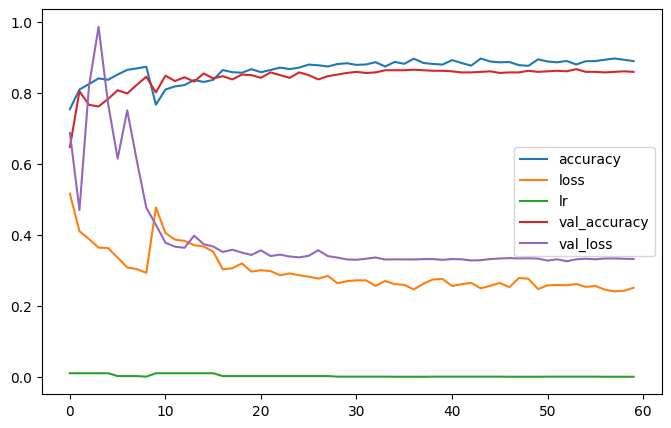

In [69]:
history_df.reset_index(drop=True).plot(figsize= (8,5));

## Saving and Loading Model

In [61]:
model = load_model(os.path.join(CKPT_DIR, CKPT_FILE_NAME))
model.save(MODEL_NAME)

In [81]:
model = load_model(MODEL_NAME)

## Model Evaluation

In [17]:
%load_ext tensorboard
%tensorboard --logdir logs 

In [82]:
#Get the last conv layer name
for layer in model.layers[-15:]:
    print(layer.name)

conv5_block32_1_relu
conv5_block32_2_conv
conv5_block32_concat
bn
relu
conv2d
global_max_pooling2d
dense
batch_normalization
activation
dense_1
batch_normalization_1
activation_1
flatten
dense_2


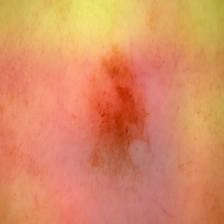

In [92]:
gradcam = GradCam(model, "conv2d", "./dataset/test/malignant/13.jpg" )
gradcam.save_and_display_gradcam()

In [94]:
# Prediction through GradCam
np.argmax(gradcam.preds.numpy())

1

In [95]:
# checking the accuracy 
accuracy = model.evaluate(valid_generator)
print('\n', 'Test_Accuracy:', accuracy[1])

42/42 [==============================] - 7s 168ms/step - loss: 0.2809 - accuracy: 0.8924

 Test_Accuracy: 0.8924242258071899


In [96]:
eval= Evaluator(model, train_generator, valid_generator)

42/42 [==============================] - 10s 154ms/step


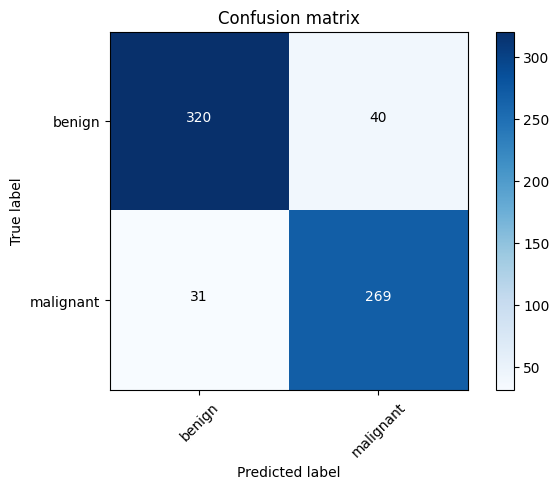

In [97]:
eval.confusion_matrix();

In [98]:
eval.classification_report()

              precision    recall  f1-score   support

      benign       0.89      0.91      0.90       351
   malignant       0.90      0.87      0.88       309

    accuracy                           0.89       660
   macro avg       0.89      0.89      0.89       660
weighted avg       0.89      0.89      0.89       660



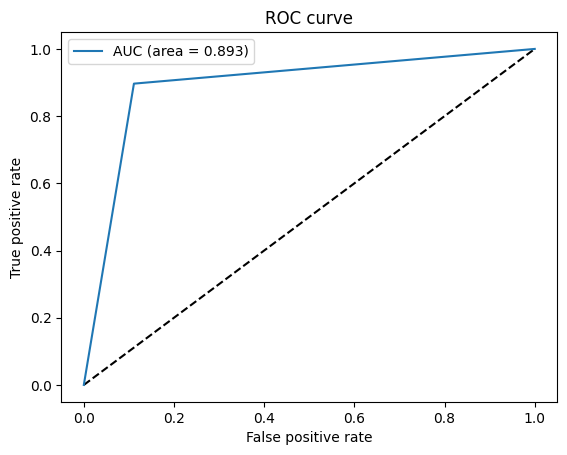

In [99]:
eval.auc_roc();

In [100]:
images, labels = valid_generator.next()
model.predict(np.expand_dims(images[0], axis=0))

1/1 [==============================] - 2s 2s/step


array([[0.04357217, 0.94811517]], dtype=float32)

Found 2637 images belonging to 2 classes.
Found 660 images belonging to 2 classes.
1/1 [==============================] - 0s 60ms/step


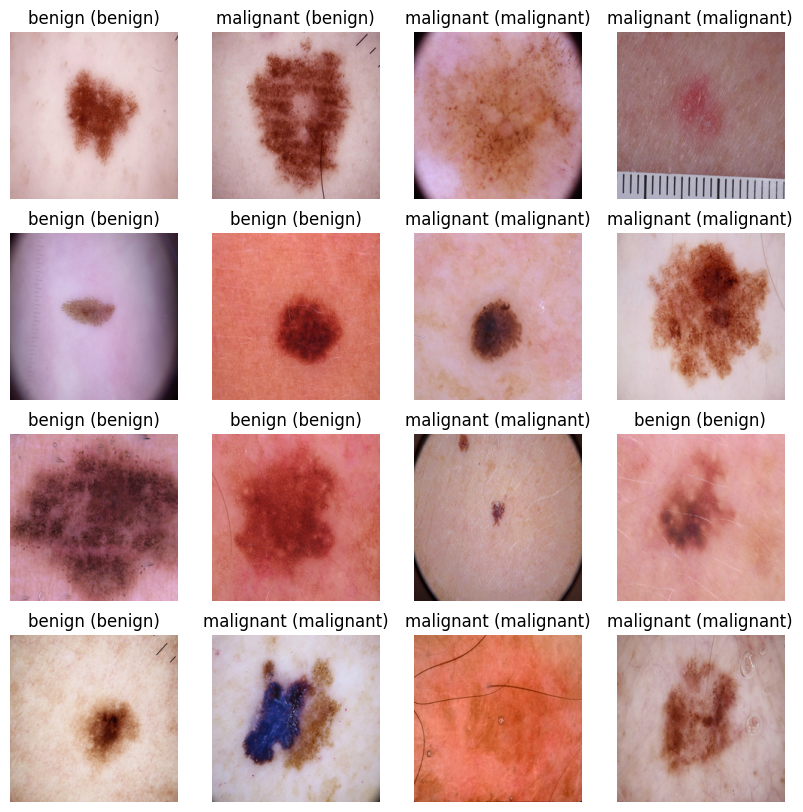

In [101]:
_, valid_generator_with_shuffle = data_ops.data_generators(train_dir=TRAIN_DIR, val_shuffle=True, val_dir=TEST_DIR, batch_size=16)
#plot a random sample of test images, their predicted labels, and ground truth
classes = list(train_generator.class_indices.keys())
plt.figure(figsize=(10, 10))
images, labels = valid_generator_with_shuffle.next()
labels = np.argmax(labels, axis=1)
for i in range(16):
    ax = plt.subplot(4, 4, i + 1)
    prediction = classes[np.argmax(model.predict(np.expand_dims(images[i], axis=0))[0], axis=0)]
    plt.imshow(images[i])
    plt.title(f"{classes[labels[i]]} ({prediction})")
    plt.axis("off")

In [102]:
## Making prediction
np.set_printoptions(suppress=True) #prevent numpy exponential presentation
img_arr = np.asarray(Image.open("./dataset/test/malignant/13.jpg"))
resized_input_img = tf.image.resize(img_arr, (244,244))
final_img = np.expand_dims(resized_input_img, axis=0)
final_img.shape

(1, 244, 244, 3)

In [103]:
prediction = model.predict(final_img)
pred_cls_label = np.argmax(prediction, axis=1)[0]
pred_cls_label

1/1 [==============================] - 2s 2s/step


1

In [104]:
np.set_printoptions(suppress=True)
print(f"Probability of being Benign is {round(prediction[0][0]*100, 5)} %")
print(f"Probability of being Malignant is {round(prediction[0][1]*100, 5)} %")

Probability of being Benign is 0.00011 %
Probability of being Malignant is 99.99981 %


In [105]:
pred_cls = eval.class_names[pred_cls_label]
pred_cls

'malignant'